# Script to validate MCAC after major modifications

## Table of Contents
1. [Introduction](#Introduction)
2. [Parameters](#Parameters)
2. [Read and compute](#Read_and_compute)
3. [Results](#Results)
    1. [Residence time](#Residence_time)
    2. [Volume fraction](#Volume_fraction)
    3. [Diffusion coefficient](#Diffusion_coefficient)
    4. [Particle number concentration](#Particle_number_concentration)
    5. [Gas Knudsen number](#Knudsen)
    6. [Radius of gyration](#gyration)
    7. [Aggregate polydispersity](#polydispersity)
    8. [Total energy](#energy)

## Introduction <a class="anchor" id="Introduction"></a>

This Python script aims at validating MCAC by comparing with a "well known" case already simulated in a previous version of the code (published results). This is referred as "ref_case" compared with the new simulation "new_case".

In this particular code only coagulation takes place without other mechanisms of particle growth or nucleation. The aspects of the code to be validated are: the mobility (diffusion coefficient D), kinetics of aggregation (number of clusters: Nc, the size of the box: L_box, and the particle number concentration: N), flow regime (Gas Knudsen number) morpholoogy (Rg vs. Np, fractal dimension and prefactor), and aggregate polydispersity (GSD of Dv). Finally, the conservation of energy (only kinetic since interaction potential are not simulated) is tested.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from sklearn.linear_model import LinearRegression

from pymcac import dask_distribute
from pymcac import MCAC
from pymcac import groupby_agg
from pymcac import progress_compute
from pymcac import mobility_diameter
from pymcac.tools.core.groupby import groupby_aggregate
from pymcac.tools import overlapping


In [2]:
def add_missing_quantities(xAggregates, xSpheres):

    xAggregates["log_Rv"] = np.log((6 * xAggregates.Volume / np.pi)) / 3
    xAggregates["Ec"] = 0.5 * xAggregates.Volume * rhop_0 * (xAggregates.lpm / xAggregates.Deltat) ** 2

    xAggregates["Dm"] = mobility_diameter(xAggregates.f_agg,
                           A1=A1, A2=A2, A3=A3, lambda_g=lambda_g, mu_g=mu_g)
    xAggregates["Kn"] = 2 * lambda_g / xAggregates["Dm"]

    xMeanRp = groupby_agg(xSpheres,
                          by=["Time", "Label"],
                          agg=[("Radius", "mean", "Radius")],
                          index_arrays=[xAggregates.kTime, xAggregates.kLabel])
    # rechunking to align xMeanRp on xAggregates
    xMeanRp = xMeanRp.chunk({"k": xAggregates.chunks["k"]})
    # using xMeanRp.data avoid triggering a computation
    # due to possibly misaligned coordinates
    # (groupby_agg sorts by default so this can be skipped)
    xAggregates["DgOverDp"] = xAggregates.Rg / xMeanRp["Radius"].data
    
    overlaps = overlapping(xSpheres, xAggregates)                           
    xAggregates = xAggregates.update(overlaps).unify_chunks()
    
    return xAggregates, xSpheres

In [3]:
def time_averaged_quantities(xAggregates, xSpheres):

    time_averaged = groupby_agg(xAggregates,
                                by="Time",
                                index_arrays=xAggregates.Time,
                                agg=[
        ("f_agg", "mean","f_agg"),
        ("Np", "mean","Np"),
        ("Rg", "mean","Rg"),
        ("DgOverDp", "mean","DgOverDp"),
        ("Dm", "mean","Dm"),
        ("Kn", "mean","Kn"),
        ("Nc", "size","Np"),
        ("Ec", "sum","Ec"),
        ("fv", "sum","Volume"),
        ("Rv_geo", "mean","log_Rv"),
        ("sv_geo", "std","log_Rv"),
        ("cij_av", "max","cij_av"),
        ("n_c_avg", "max","n_c_avg")
    ])
    BoxVolume = xAggregates.BoxVolume.chunk({"Time": -1})
    time_averaged["fv"] /= BoxVolume
    time_averaged["Rv_geo"] = np.exp(time_averaged.Rv_geo)
    time_averaged["sv_geo"] = np.exp(time_averaged.sv_geo)

    time_averaged["Nc density"] = time_averaged.Nc / BoxVolume
    time_averaged["Diffusion"] = k_B * T_g / time_averaged.f_agg

    time_averaged["Dm_avg"] = mobility_diameter(time_averaged.f_agg,
                                                A1=A1, A2=A2, A3=A3, lambda_g=lambda_g, mu_g=mu_g)
    time_averaged["Kn_avg"] = 2 * lambda_g / time_averaged["Dm_avg"]

    xMeanRp = groupby_agg(xSpheres,
                          by="Time",
                          agg=[("Radius", "mean", "Radius")],
                          index_arrays=xSpheres.Time,)
    # rechunking to align xMeanRp on xAggregates
    xMeanRp = xMeanRp.chunk({"Time": xAggregates.chunks["Time"]})
    # using xMeanRp.data avoid triggering a computation
    # due to possibly misaligned coordinates
    # (groupby_agg sorts by default so this can be skipped)
    time_averaged["DgOverDp_avg"] = time_averaged.Rg / xMeanRp.data

    time_averaged = time_averaged.reset_coords("nLabel")

    return time_averaged

In [4]:
def read(path, tmax=None, ncmax=None, nt=None):
    # The folder with all .h5 and .xmf files
    MCACSimulation = MCAC(path)

    # Read all data
    Spheres = MCACSimulation.get_xspheres(spheres_cols, tmax=tmax, nt=nt)
    Aggregates = MCACSimulation.get_xaggregates(aggregates_cols, tmax=tmax, nt=nt)

    print(Spheres.BoxVolume.values)
    print(Aggregates.BoxVolume.values)

    # Per aggregate computations
    Aggregates, Spheres = add_missing_quantities(Aggregates, Spheres)
    
    # Per time-step computations
    time_averaged = time_averaged_quantities(Aggregates, Spheres)

    return MCACSimulation, time_averaged

In [5]:
def plot_compare(ds1, ds2, x, y, xlabel=None, ylabel=None, **kwargs):
    fig = plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    fig.set_tight_layout(False)

    kwargs["ax"] = kwargs.get("ax", plt.gca())

    if x is None:
        x = next(iter(ds1.coords))

    if isinstance(y, str):
        y = [y]

    if isinstance(ds1, xr.DataArray):
        ds1 = ds1.to_dataset()
    if isinstance(ds2, xr.DataArray):
        ds2 = ds2.to_dataset()

    df1 = ds1[[x]+y].to_dataframe()
    df2 = ds2[[x]+y].to_dataframe()

    if x in df1.columns:
        df1 = df1.set_index(x)
        df2 = df2.set_index(x)
    df1 = df1.sort_index()
    df2 = df2.sort_index()

    df1.plot(**kwargs, style="-")
    df2.plot(**kwargs, style="--")

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    plt.legend([f"New {varname}" for varname in y] + [f"Ref {varname}" for varname in y])
    plt.show()

## Parameters <a class="anchor" id="Parameters"></a>

Check these parameters before running the script!

In [6]:
T_g = 1_700  # temperature in K
P_g = 101_300  # pressure in Pa
rhop_0 = 1_800  # particle bulk density in kg/m^3
k_B = 1.38066E-23  # Boltzmann constant in J/K

# gas mean free path and viscosity
lambda_g = 66.5E-9 * (101_300 / P_g) * (T_g / 293.15) * (1 + 110 / 293.15) / (1 + 110 / T_g)  # in m
mu_g = 18.203E-6 * (293.15 + 110) / (T_g + 110) * (T_g / 293.15) ** 1.5  # in Ps*s

# for Cunningham slip correction factor: Cc
A1 = 1.142
A2 = 0.558
A3 = 0.999

spheres_cols = ["Radius", "Label", "Posx", "Posy", "Posz", "BoxVolume"]
aggregates_cols = ["Volume", "lpm", "Deltat", "f_agg", "Rg", "Np", "BoxVolume"]

reference_path = Path("/stockage/samba/Partages/public/MCAC_validation/06_Surface_growth/06p4_validation/run1")
result_path = Path("surfacegrowth_data")

## Read and compute  <a class="anchor" id="Read_and_compute"></a>

You can look at the dashboard to see progress in more details

In [7]:
with dask_distribute(report=True) as c:
    display(c)
    print("Reading new")
    newSimulation, new_time_averaged = read(result_path, nt=100)

    print("Reading reference")
    refSimulation, ref_time_averaged = read(reference_path, nt=100)

    print("Start compute")
    new_time_averaged, ref_time_averaged = progress_compute(new_time_averaged, ref_time_averaged)
print("Done")

Client Scheduler: tcp://127.0.0.1:41657 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 31.28 GiB



  File "/Data/WORK/Projets/SRC/MCAC/venv/lib/python3.9/site-packages/distributed/scheduler.py", line 4096, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/Data/WORK/Projets/SRC/MCAC/venv/lib/python3.9/site-packages/distributed/scheduler.py", line 5184, in handle_worker
    await self.handle_stream(comm=comm, extra={"worker": worker})
  File "/Data/WORK/Projets/SRC/MCAC/venv/lib/python3.9/site-packages/distributed/core.py", line 572, in handle_stream
    handler(**merge(extra, msg))
  File "/Data/WORK/Projets/SRC/MCAC/venv/lib/python3.9/site-packages/distributed/scheduler.py", line 5084, in handle_release_data
    ws: WorkerState = parent._workers_dv[worker]
KeyError: 'tcp://127.0.0.1:39999'
distributed.core - ERROR - Exception while handling op register-worker
Traceback (most recent call last):
  File "/Data/WORK/Projets/SRC/MCAC/venv/lib/python3.9/site-packages/distributed/core.py", line 498, in handle_comm
    result = await result
  File "/Data/WORK/P

KeyboardInterrupt: 

## Results <a class="anchor" id="Results"></a>

In [8]:
new_time_averaged

<xarray.Dataset>
Dimensions:       (Time: 100)
Coordinates:
  * Time          (Time) float64 0.0 2.751e-06 5.498e-06 ... 0.0002692 0.0002719
Data variables: (12/19)
    f_agg         (Time) float64 3.389e-14 3.621e-14 ... 4.921e-13 4.973e-13
    Np            (Time) float64 1.0 1.124 1.242 1.325 ... 38.1 38.79 39.51 40.0
    Rg            (Time) float64 3.952e-09 4.207e-09 ... 2.614e-08 2.633e-08
    DgOverDp      (Time) float64 0.7796 0.8301 0.8813 ... 5.078 5.143 5.18
    Dm            (Time) float64 1.02e-08 1.051e-08 ... 3.494e-08 3.515e-08
    Kn            (Time) float64 101.0 98.62 95.85 94.38 ... 39.74 39.23 39.0
    ...            ...
    nLabel        (Time) int64 800 712 644 604 558 504 ... 171 168 165 162 160
    Nc density    (Time) float64 1.645e+19 1.464e+19 ... 4.163e+17 4.111e+17
    Diffusion     (Time) float64 6.925e-07 6.482e-07 ... 4.769e-08 4.719e-08
    Dm_avg        (Time) float64 1.039e-08 1.074e-08 ... 3.973e-08 3.994e-08
    Kn_avg        (Time) float64 95.93 92.8 89.56 87.61 ... 25.28 25.08 24.94
    DgOverDp_avg  (Time) float64 0.7796 0.8298 0.8816 ... 5.075 5.141 5.178

In [9]:
ref_time_averaged

<xarray.Dataset>
Dimensions:       (Time: 97)
Coordinates:
  * Time          (Time) float64 0.0 3.538e-06 6.958e-06 ... 0.0003412 0.0003441
Data variables: (12/19)
    f_agg         (Time) float64 3.301e-14 3.612e-14 ... 6.566e-13 6.732e-13
    Np            (Time) float64 1.0 1.143 1.294 1.457 ... 57.66 58.72 60.38
    Rg            (Time) float64 3.906e-09 4.231e-09 ... 3.136e-08 3.197e-08
    DgOverDp      (Time) float64 0.7746 0.8401 0.9044 0.965 ... 6.11 6.184 6.304
    Dm            (Time) float64 1.009e-08 1.049e-08 ... 3.99e-08 4.055e-08
    Kn            (Time) float64 102.0 99.19 96.4 93.82 ... 36.9 36.61 35.97
    ...            ...
    nLabel        (Time) int64 800 700 618 549 487 444 ... 119 114 111 109 106
    Nc density    (Time) float64 1.645e+19 1.645e+19 ... 1.645e+19 1.645e+19
    Diffusion     (Time) float64 7.111e-07 6.498e-07 ... 3.575e-08 3.486e-08
    Dm_avg        (Time) float64 1.025e-08 1.072e-08 ... 4.593e-08 4.651e-08
    Kn_avg        (Time) float64 97.21 92.92 89.03 85.47 ... 21.86 21.69 21.42
    DgOverDp_avg  (Time) float64 0.7746 0.839 0.9023 ... 6.121 6.195 6.316

### Residence time <a class="anchor" id="Residence_time"></a>

In [11]:
print(f" Ref total residence time: "
      f"{float(ref_time_averaged.Time[-1] - ref_time_averaged.Time[0]) * 1e3} (ms) "
      f"({ref_time_averaged.Time.size} it)")
print(f" New total residence time: "
      f"{float(new_time_averaged.Time[-1] - new_time_averaged.Time[0]) * 1e3} (ms) "
      f"({new_time_averaged.Time.size} it)")

 Ref total residence time: 0.344079 (ms) (97 it)
 New total residence time: 0.271857 (ms) (100 it)


### Volume fraction <a class="anchor" id="Volume_fraction"></a>

 ref volume fraction = 9.727282911228759 ppm
 new volume fraction = 10.000003073760208 ppm


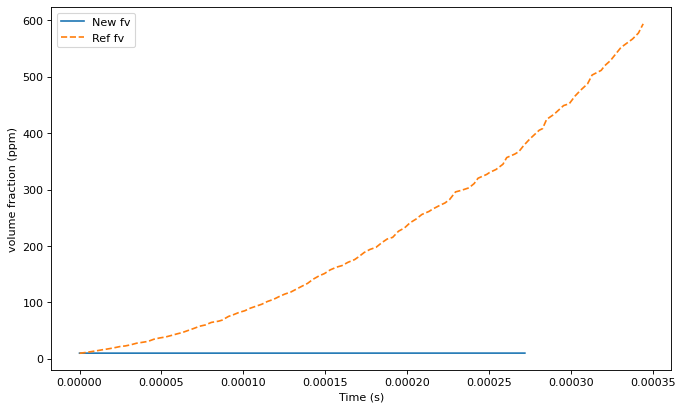

In [12]:
print(f" ref volume fraction = {float(ref_time_averaged.fv[0]) * 1e+06} ppm")
print(f" new volume fraction = {float(new_time_averaged.fv[0]) * 1e+06} ppm")
plot_compare(new_time_averaged.fv * 1e+06, ref_time_averaged.fv * 1e+06,
             x=None, xlabel="Time (s)",
             y="fv", ylabel="volume fraction (ppm)",
             loglog=False)

### Diffusion coefficient <a class="anchor" id="Diffusion_coefficient"></a>

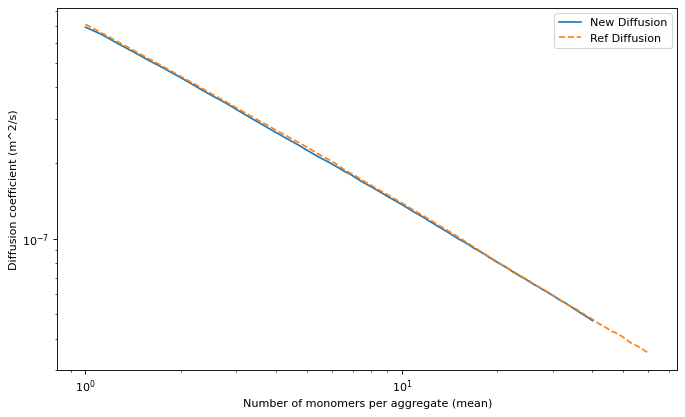

In [13]:
# Comparison of diffusion coefficients allow to check: temperature, friction coefficient,
# fLuid viscosity. Becareful, f_agg depends on the fractal dimension!
plot_compare(new_time_averaged, ref_time_averaged,
             x="Np", xlabel="Number of monomers per aggregate (mean)",
             y="Diffusion", ylabel="Diffusion coefficient (m^2/s)",
             loglog=True)

### Particle number concentration <a class="anchor" id="Particle_number_concentration"></a>

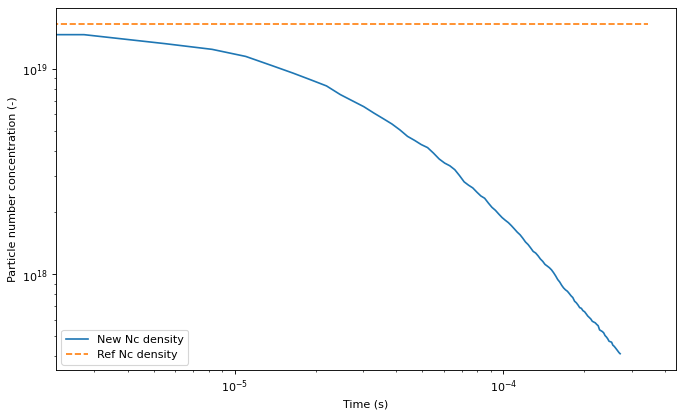

Ref case initialized with 800 monomers
New case initialized with 800 monomers


In [14]:
# plot_compare(new_time_averaged, ref_time_averaged,
#              x=None, xlabel="Time (s)",
#              y="Nc", ylabel="Number of aggregate (-)",
#              loglog=True)
# plot_compare(new_time_averaged, ref_time_averaged,
#              x=None, xlabel="Time (s)",
#              y="BoxSize", ylabel="Box size (m)",
#              loglog=True)
plot_compare(new_time_averaged, ref_time_averaged,
             x=None, xlabel="Time (s)",
             y="Nc density", ylabel="Particle number concentration (-)",
             loglog=True)
print(f"Ref case initialized with {int(ref_time_averaged.Nc[0])} monomers")
print(f"New case initialized with {int(new_time_averaged.Nc[0])} monomers")

### Gas Knudsen number <a class="anchor" id="Knudsen"></a>

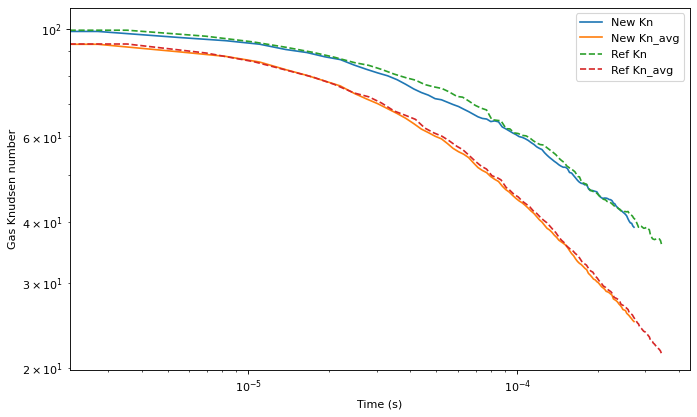

In [15]:
plot_compare(new_time_averaged, ref_time_averaged,
             x=None, xlabel="Time (s)",
             y=["Kn", "Kn_avg"], ylabel="Gas Knudsen number",
             loglog=True)

### Radius of gyration <a class="anchor" id="gyration"></a>

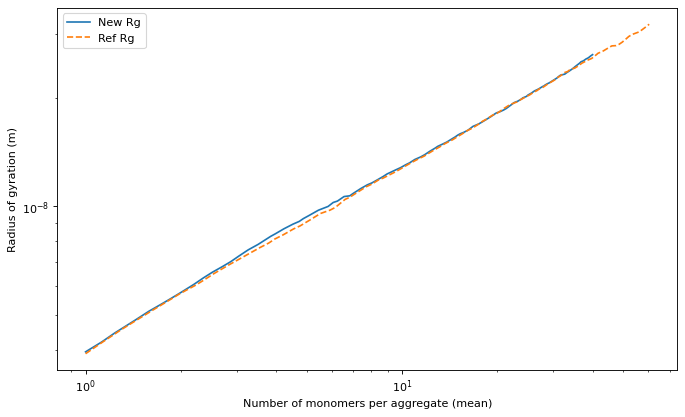

In [16]:
# Allows to check the role played by monomer mass is correcly considered for each
# agglomerate. Also, according to Np and the fractal dimension they should have
# comparable values.
plot_compare(new_time_averaged, ref_time_averaged,
             x="Np", xlabel="Number of monomers per aggregate (mean)",
             y="Rg", ylabel="Radius of gyration (m)",
             loglog=True)

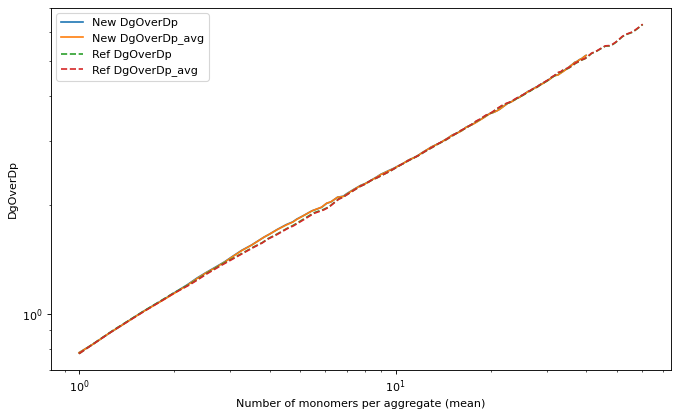

In [17]:
plot_compare(new_time_averaged, ref_time_averaged,
             x="Np", xlabel="Number of monomers per aggregate (mean)",
             y=["DgOverDp", "DgOverDp_avg"], ylabel="DgOverDp",
             loglog=True)

In [18]:
# The population-based fractal dimension and prefactor
# Becareful: There is variability on these parameters for individual simulations.

model = LinearRegression()
model.fit(np.log(ref_time_averaged.DgOverDp_avg).values[:, np.newaxis],
          np.log(ref_time_averaged.Np))
print(f"Ref fractal Law: {np.exp(model.intercept_)} x^{model.coef_[0]}")

model.fit(np.log(new_time_averaged.DgOverDp_avg).values[:, np.newaxis],
          np.log(new_time_averaged.Np))
print(f"New fractal Law: {np.exp(model.intercept_)} x^{model.coef_[0]}")

Ref fractal Law: 1.5683639384310504 x^1.987648223112761
New fractal Law: 1.526903900994037 x^2.0070684649076007


### Aggregate polydispersity  <a class="anchor" id="polydispersity"></a>

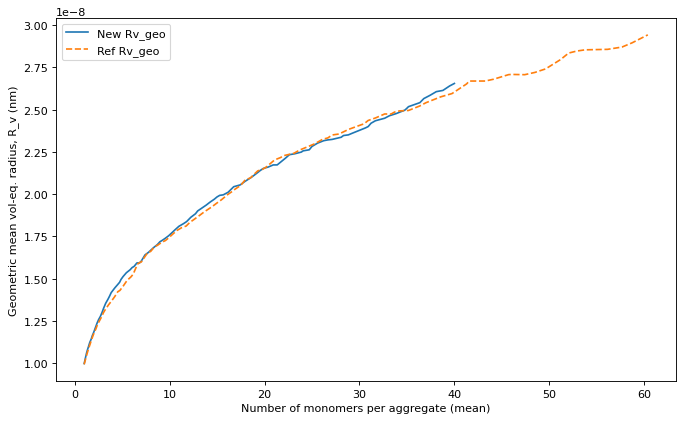

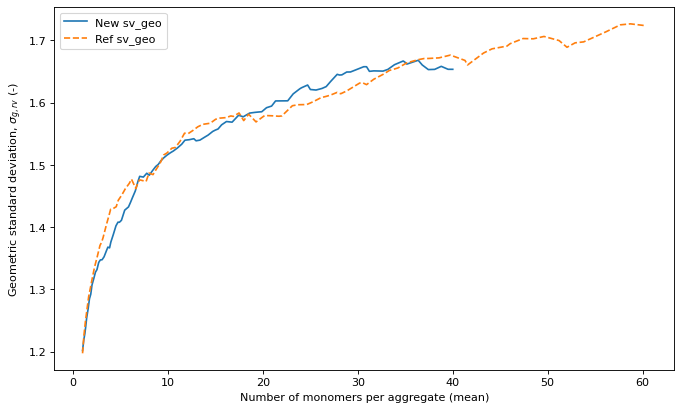

In [19]:
plot_compare(new_time_averaged, ref_time_averaged,
             x="Np", xlabel="Number of monomers per aggregate (mean)",
             y="Rv_geo", ylabel="Geometric mean vol-eq. radius, R_v (nm)",
             loglog=False)
plot_compare(new_time_averaged, ref_time_averaged,
             x="Np", xlabel="Number of monomers per aggregate (mean)",
             y="sv_geo", ylabel="Geometric standard deviation, $\sigma_{g,rv}$ (-)",
             loglog=False)

### Total energy  <a class="anchor" id="energy"></a>

The total kinetic energy of the system of $N$ particles is, $$K=\sum_i^{N} \frac{1}{2}m_ic_i^2$$
where $m_i$ and $c_i=\frac{lpm_i}{\Delta t_i}$ are the mass and averaged velocity of the $i^{th}$ particle, respectively.

From the kinetic theory of gases we have, $$\frac{1}{2}m_ic_i^2=\frac{3}{2}k_BT$$

Therefore, the total energy is related to the temperature as, $$E_{tot}=N\frac{3}{2}k_BT=K$$

3/2 kb T = 3.5206830000000005e-20
 ref K/N = 2.347121999999995e-20
 new K/N = 2.3026507819440767e-20


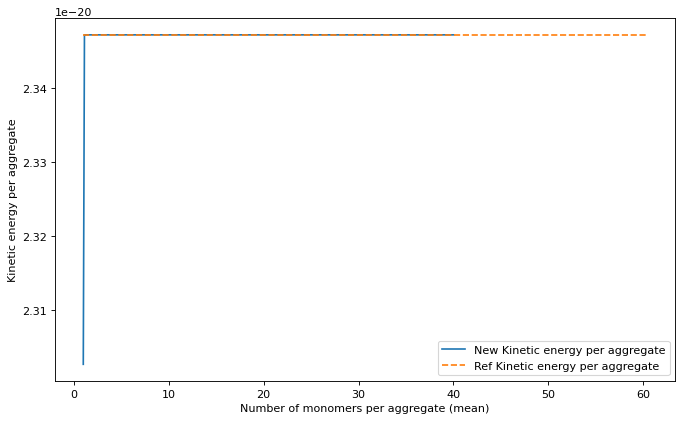

In [20]:
new_time_averaged["Kinetic energy per aggregate"] = new_time_averaged.Ec / new_time_averaged.Nc
ref_time_averaged["Kinetic energy per aggregate"] = ref_time_averaged.Ec / ref_time_averaged.Nc

print(f"3/2 kb T = {1.5 * k_B * T_g}")
print(f" ref K/N = {float(ref_time_averaged['Kinetic energy per aggregate'][0])}")
print(f" new K/N = {float(new_time_averaged['Kinetic energy per aggregate'][0])}")

plot_compare(new_time_averaged, ref_time_averaged,
             x="Np", xlabel="Number of monomers per aggregate (mean)",
             y="Kinetic energy per aggregate", ylabel="Kinetic energy per aggregate",
             loglog=False)

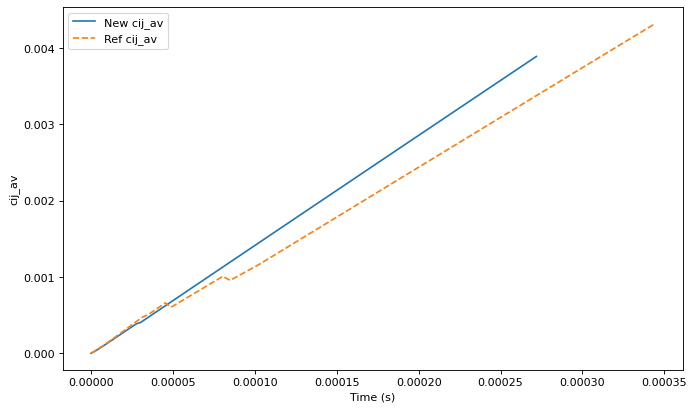

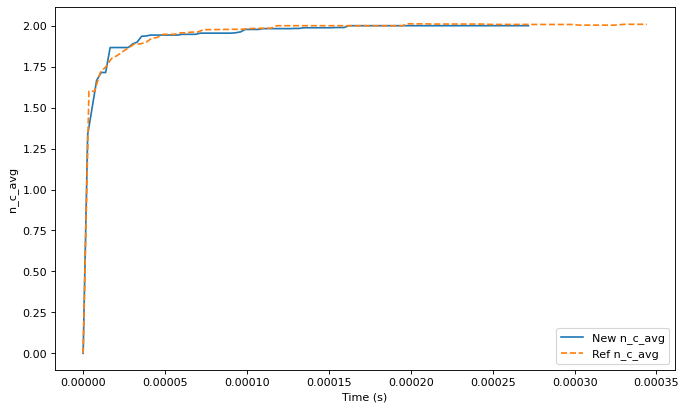

In [21]:
plot_compare(new_time_averaged, ref_time_averaged,
             x=None, xlabel="Time (s)",
             y="cij_av", ylabel="cij_av",
             loglog=False)
plot_compare(new_time_averaged, ref_time_averaged,
             x=None, xlabel="Time (s)",
             y="n_c_avg", ylabel="n_c_avg",
             loglog=False)